# Preface

Objectives:
1. Learn to use the `keras` API
2. Explore how performance of fully connected neural networks depend on its hyper-parameters
3. Explore the effect of learning rate and batch size on training and testing performance

In [1]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
sns.set(font_scale=1.5)

# The Fashion MNIST Dataset

As mentioned in class the saying,
> *If you model works for MNIST, it may not work for anything else, but if it doesn't work for MNIST, it won't work for anything else*

Here in this notebook you will go beyond the MNIST dataset, albeit only a little bit. We will use the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset, which is designed to replace MNIST as the new minimal dataset to test vision tasks. 

It is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Thus, it is almost exactly like the MNIST dataset for digit recognition, but the classification problem is generally harder.


Here are some example images:
![Fashion MNIST](https://markusthill.github.io/images/2017-10-12-zalandos-fashion-mnist-dataset/zalando10x10.jpeg)

# Importing the Dataset

Just like MNIST, this dataset is found in the `tf.keras.datasets` module.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

The following is a dictionary of labels that will map the y_train/y_test labels into words

In [3]:
label_dict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot',
}
labels_train = [label_dict[u] for u in y_train]
labels_test = [label_dict[u] for u in y_test]

Text(0.5, 1, 'Label = Ankle boot')

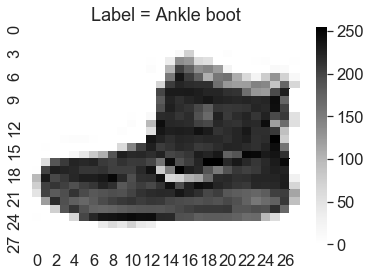

In [4]:
ax = sns.heatmap(x_train[0], cmap='Greys')
ax.set_title(f'Label = {labels_train[0]}')

# Task 1: Build a Shallow NN for Classification

Build and train a shallow (one-hidden-layer) neural network with 128 hidden nodes to classify these images. Remember to perform appropriate preprocessing steps, such as normalization and one-hot representations.

Evaluate carefully the performance of your training and the final model's performance. Discuss any interesting phenomena you discover.

## Normalize, Reshape and Convert to onehot

In [5]:
x_train = x_train.reshape(-1, 784) / 255.0
x_test = x_test.reshape(-1, 784) / 255.0
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

## Build a Shallow Neural network

We will use the `Sequential` model again.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [7]:
model = Sequential()
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

## Compile and Train

We are going to use the `adam` optimizer, which is an adaptive version of SGD with momentum. You can also try other ones, such as `RMSprop`, `Adagrad` or simply tune the momentum parameter in `SGD`

The 'tqdm.keras' library provides a nice callback that makes a easy-to-read progress bar.

In [8]:
from tensorflow.keras.optimizers import Adam
from tqdm.keras import TqdmCallback

Using TensorFlow backend.


In [9]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy'],
)

In [10]:
history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test, y_test),
    batch_size=128,
    epochs=100,
    callbacks=[TqdmCallback()],
    verbose=0,
)

The `fit` method returns training statistics that we can analyze using various plotting libraries.

In [11]:
results = pd.DataFrame(history.history)
results['epoch'] = history.epoch

In [12]:
results.head()

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.556138,0.807967,0.455147,0.8420,0
1,0.402081,0.859500,0.420614,0.8514,1
2,0.361556,0.872517,0.399509,0.8592,2
3,0.338852,0.879083,0.379623,0.8642,3
4,0.317823,0.885050,0.364430,0.8692,4


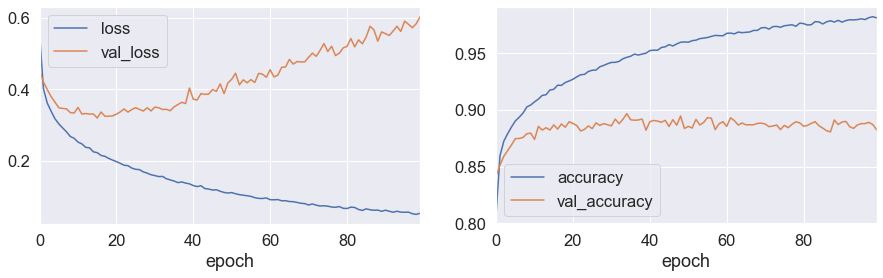

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

results.plot(x='epoch', y=['loss', 'val_loss'], ax=ax1)
results.plot(x='epoch', y=['accuracy', 'val_accuracy'], ax=ax2)

Interestingly, observe from the loss plot on the left that the model appears to "over-fit", in the sense that after around epoch 20, the validation loss (on the test set) begins to increase. However, if you look at the right plot, the test accuracy did not increase, and merely flattens. 

This is because ultimately, the cross-entropy loss is just a **surrogate** for the classification accuracy, and they need not increase or decrease together all the time!

We can also take a look at the confusion matrix

In [14]:
from sklearn.metrics import confusion_matrix

Text(0.5, 1, 'Confusion Matrix (without diagonal)')

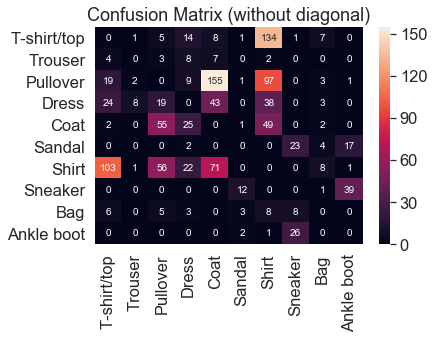

In [15]:
y_test_predict = model.predict(x_test)

cmatrix = confusion_matrix(y_true=y_test.argmax(1), y_pred=y_test_predict.argmax(1))
np.fill_diagonal(cmatrix, 0)
ax = sns.heatmap(cmatrix, annot=True, fmt="d")
label_text = [label_dict[j] for j in range(10)]
ax.set_xticklabels(label_text, rotation=90)
ax.set_yticklabels(label_text, rotation=0)
ax.set_title('Confusion Matrix (without diagonal)')

# Task 2: Dependence on Hyper-parameters

Now, investigate the dependence of the neural network's performance on some hyper-parameters. In particular, investigate the dependence on the following:

1. Number of hidden nodes
2. The activation function
3. Loss functions

Discuss any interesting findings. 

## Writing a testing pipline

Whenever testing/debugging models with different parameters, we should write a model building, training and evaluation pipeline so performance can be compared easily without rewriting code.

In [16]:
from pathlib import Path

In [17]:
def build_and_train(data, save_path, **kwargs):

    # Check if save file exist, if so, load it
    model_path = save_path.with_suffix('.h5')
    results_path = save_path.with_suffix('.json')
    
    if model_path.exists() and results_path.exists():
        model = tf.keras.models.load_model(filepath=model_path)
        results = pd.read_json(path_or_buf=results_path)
        results = results.sort_values(by='epoch')
        print(f'Model loaded from {save_path}')
        
    # otherwise, we build and train a new model
    else:
        # Build model
        activation = kwargs.get('activation', 'relu')
        units = kwargs.get('units', 128)
        model = Sequential()
        model.add(Dense(units, activation=activation))
        model.add(Dense(10, activation='softmax'))

        # Compile
        loss = kwargs.get('loss', 'categorical_crossentropy')
        optimizer = kwargs.get('optimizer', Adam())
        model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

        # Train
        batch_size = kwargs.get('batch_size', 128)
        epochs = kwargs.get('epochs', 100)
        x_train, y_train, x_test, y_test = data
        history = model.fit(
            x=x_train,
            y=y_train,
            validation_data=(x_test, y_test),
            batch_size=batch_size,
            epochs=epochs,
            callbacks=[TqdmCallback(verbose=0)],
            verbose=0,
        )
    
        # Output Results
        results = pd.DataFrame(history.history)
        results['epoch'] = history.epoch
        model.save(filepath=save_path.with_suffix('.h5'))
        results.to_json(save_path.with_suffix('.json'))
    
    return model, results

In [18]:
def pipeline(data, parameter_name, parameter_values, save_dir='save'):
    save_dir = Path(save_dir)
    save_dir.mkdir(exist_ok=True)

    # Build and train models for differet parameters
    models, results = [], []
    for value in parameter_values:
        m, r = build_and_train(
            data=(x_train, y_train, x_test, y_test),
            save_path=save_dir.joinpath(f'{parameter_name}_{value}'),
            **{parameter_name: value},
        )
        models.append(m)
        results.append(r)

    # Plot results
    fig, ax = plt.subplots(2, 2, figsize=(15, 8), sharey='row')

    for j, value in enumerate(parameter_values):
        ax[0, 0].semilogy(results[j].epoch,
                          results[j].loss,
                          label=f'{parameter_name}={value}')
        ax[0, 1].semilogy(results[j].epoch,
                          results[j].val_loss,
                          label=f'{parameter_name}={value}')
        ax[1, 0].plot(results[j].epoch,
                      results[j].accuracy,
                      label=f'{parameter_name}={value}')
        ax[1, 1].plot(results[j].epoch,
                      results[j].val_accuracy,
                      label=f'{parameter_name}={value}')

    for a in ax.ravel():
        a.legend()
        a.set_xlabel('epoch')

    ax[0, 0].set_title('Train Loss')
    ax[0, 1].set_title('Test Loss')
    ax[1, 0].set_title('Train Accuracy')
    ax[1, 1].set_title('Test Accuracy')

    fig.tight_layout()
        
    return models, results

## Number of hidden nodes

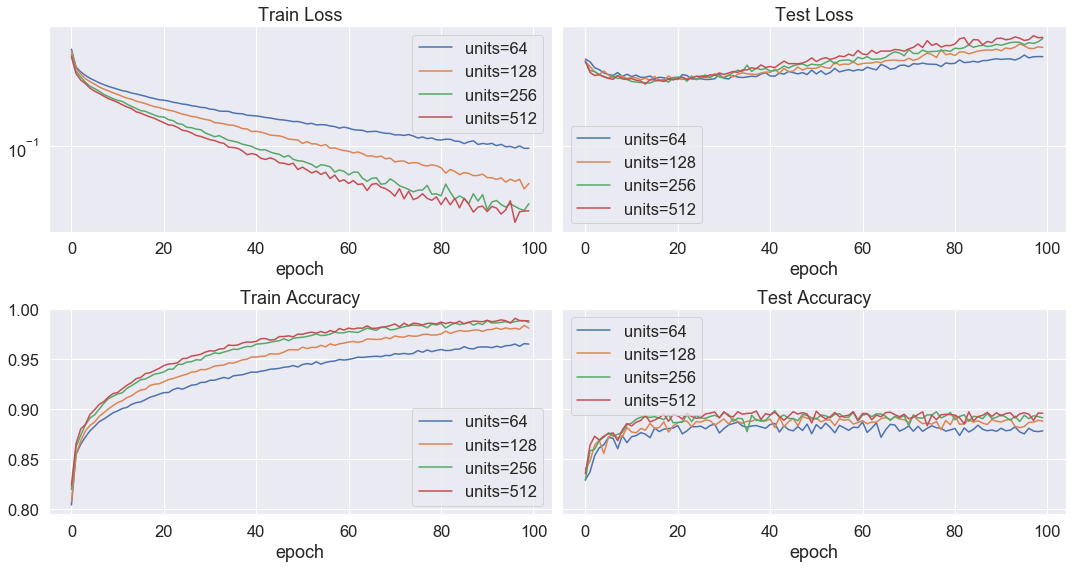

In [19]:
_ = pipeline(
    data=(x_train, y_train, x_test, y_test),
    parameter_name='units',
    parameter_values=[64, 128, 256, 512],
)

From these results, we observe that as the number of nodes increase, as expected the model capacity increases, in the sense that the train loss decreases. However, there is little difference in test error. This signifies that the main obstacle to performance now is model generalization, not capacity.

## Activation

Similarly, we can now see what difference the activation function makes.

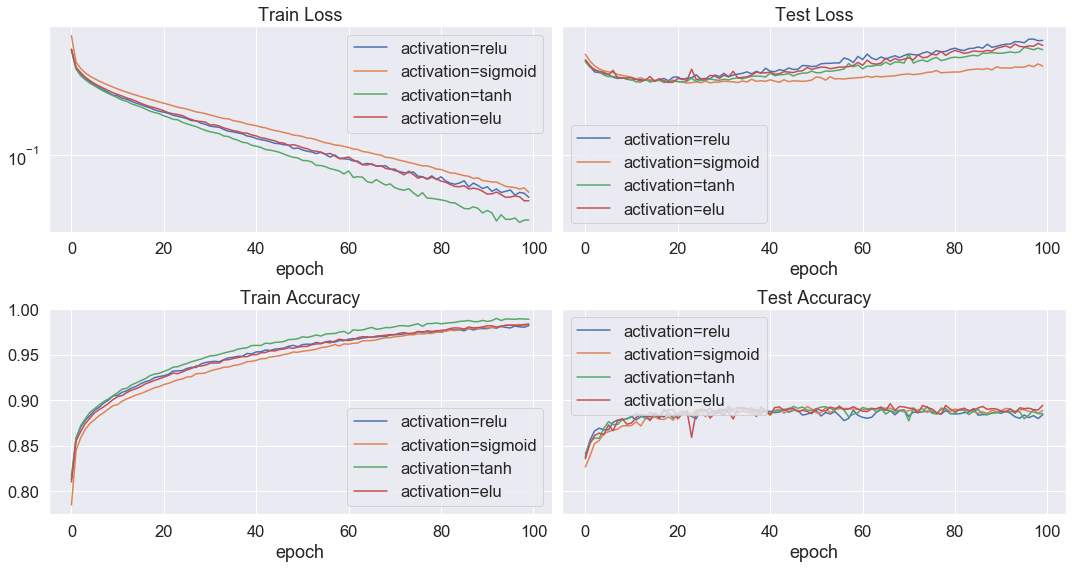

In [20]:
_ = pipeline(
    data=(x_train, y_train, x_test, y_test),
    parameter_name='activation',
    parameter_values=['relu', 'sigmoid', 'tanh', 'elu'],
)

We see that relu generally leads to slightly better results, although one should be careful about drawing such conclusions. It could be that the other activations require different tunings of the optimizer for optimal performance.

## Loss Functions

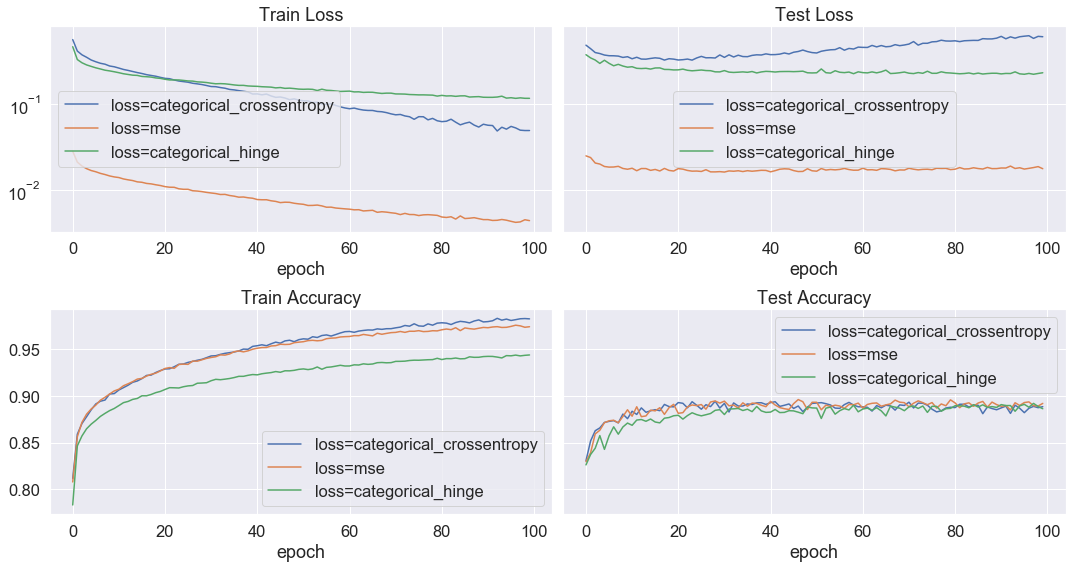

In [21]:
models, results = pipeline(
    data=(x_train, y_train, x_test, y_test),
    parameter_name='loss',
    parameter_values=['categorical_crossentropy', 'mse', 'categorical_hinge'],
)

Note: we should not directly compare the loss values in this case, since the loss functions are not expected to have the same range of outputs. For example, MSE is a squared error, which is expected to be much lower than MAE, the mean absolute error, when the error is small, since $\epsilon^2 \ll \epsilon$ for $\epsilon\ll 1$.

However, remember that all these are surrogates for the accuracy or zero-one loss, so the accuracy is a better measure of performance. It appears that the cross-entropy loss performs the best in this case in the training set, but on the test set the performance is pretty much the same.

# Further Exercises

Do the same analysis, but for other parameters, say
1. Optimization algorithms
2. Learning rate / momentum and other parameters
3. Batch size